# Mini Project: Leveraging ML for Revenue Optimization via Strategic Couponing

## Objective
We develop a predictive model that decides whether a customer should receive a **€5 voucher** after their first purchase.  
The goal is to maximize **expected revenue**.

### Business payoff structure (given)
- If we **send a voucher** to a customer who **would not reorder** (true churn), then in **25%** of cases the voucher triggers a purchase with **€10** average order value  
  ⇒ the net uplift is **€1.25** per such customer.
- If we **send a voucher** to a customer who **would reorder anyway**, we lose **€5** (discount we did not need to give).
- If we **do not send** a voucher, revenue impact is **€0**.

Therefore, we will optimize the model and its decision threshold directly for **expected revenue**.

Name : Franzi Nagel
Name : Alexander Unger

# 1. Data inspection

## 1.1 Load training data

We load the training dataset and verify shape, schema, and the target definition.


In [78]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [79]:
import os

my_dire = os.getcwd()
train = pd.read_csv('train.csv', sep=';')

/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_73281/2933119078.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv', sep=';')


## 1.2 Feature dictionary check

We compare observed columns to the data dictionary to detect missing or unexpected fields early.


In [80]:
train.columns.tolist()
train.dtypes


customernumber           int64
date                    object
salutation               int64
title                    int64
domain                   int64
datecreated             object
newsletter               int64
model                    int64
paymenttype              int64
deliverytype             int64
invoicepostcode          int64
delivpostcode           object
voucher                  int64
advertisingdatacode     object
case                     int64
numberitems              int64
gift                     int64
entry                    int64
points                   int64
shippingcosts            int64
deliverydatepromised    object
deliverydatereal        object
weight                   int64
remi                     int64
cancel                   int64
used                     int64
w0                       int64
w1                       int64
w2                       int64
w3                       int64
w4                       int64
w5                       int64
w6      

## 1.3 Target distribution

Since business value is asymmetric, we inspect class balance but optimize later for expected revenue.


In [81]:
target_col = "target90"
train[target_col].value_counts(dropna=False), train[target_col].mean()


(target90
 0    26377
 1     6051
 Name: count, dtype: int64,
 0.1865980017269027)

## 1.4 Missing values overview

We quantify missingness to guide feature engineering and imputation decisions.


In [82]:
missing = train.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(30)


delivpostcode          0.957074
advertisingdatacode    0.798847
dtype: float64

In [83]:
train.isna().sum().sort_values(ascending=False)


delivpostcode           31036
advertisingdatacode     25905
customernumber              0
deliverydatepromised        0
weight                      0
remi                        0
cancel                      0
used                        0
w0                          0
w1                          0
w2                          0
w3                          0
w4                          0
w5                          0
w6                          0
w7                          0
w8                          0
w9                          0
w10                         0
deliverydatereal            0
shippingcosts               0
date                        0
paymenttype                 0
salutation                  0
title                       0
domain                      0
datecreated                 0
newsletter                  0
model                       0
deliverytype                0
points                      0
invoicepostcode             0
voucher                     0
case      

## 1.5 Basic integrity checks

We run lightweight checks to catch impossible values and potential data issues before modeling.


In [84]:
checks = {
    "negative_weight": (train["weight"] < 0).sum() if "weight" in train.columns else None,
    "negative_numberitems": (train["numberitems"] < 0).sum() if "numberitems" in train.columns else None,
    "negative_remi": (train["remi"] < 0).sum() if "remi" in train.columns else None,
    "negative_cancel": (train["cancel"] < 0).sum() if "cancel" in train.columns else None,
    "negative_used": (train["used"] < 0).sum() if "used" in train.columns else None,
}
checks


{'negative_weight': 0,
 'negative_numberitems': 0,
 'negative_remi': 0,
 'negative_cancel': 0,
 'negative_used': 0}

## 1.6 Date parsing

We convert date-like columns to datetime to enable duration features and consistency checks.


In [85]:
# Example: account created should not be after first order (if both exist)
if "date" in train.columns and "datecreated" in train.columns:
    invalid_account_age = (train["date"] < train["datecreated"]).sum()
    invalid_account_age


## 1.7 Univariate EDA (light)

We summarize numeric variables and inspect a small set of distributions to identify skew and outliers.


In [86]:
num_cols = train.select_dtypes(include=[np.number]).columns
train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
customernumber,32428.0,33389.298569,19148.090449,1.0,16802.75,33552.5,50034.25,66251.0
salutation,32428.0,0.541569,0.657044,0.0,0.00,0.0,1.00,2.0
title,32428.0,0.006969,0.083192,0.0,0.00,0.0,0.00,1.0
domain,32428.0,7.517115,3.683945,0.0,4.00,9.0,11.00,12.0
newsletter,32428.0,0.169483,0.375184,0.0,0.00,0.0,0.00,1.0
model,32428.0,1.646910,0.825981,1.0,1.00,1.0,2.00,3.0
paymenttype,32428.0,1.000987,1.092677,0.0,0.00,1.0,2.00,3.0
deliverytype,32428.0,0.201955,0.401465,0.0,0.00,0.0,0.00,1.0
invoicepostcode,32428.0,48.752282,24.361425,0.0,30.00,47.0,66.00,99.0
voucher,32428.0,0.162020,0.368475,0.0,0.00,0.0,0.00,1.0


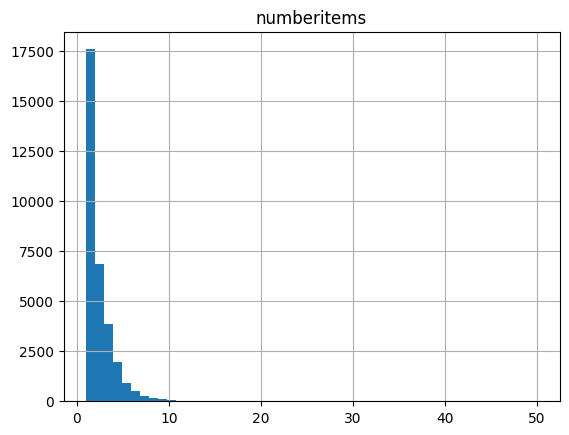

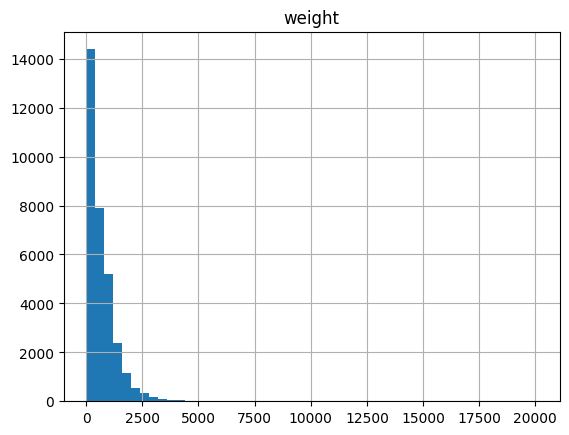

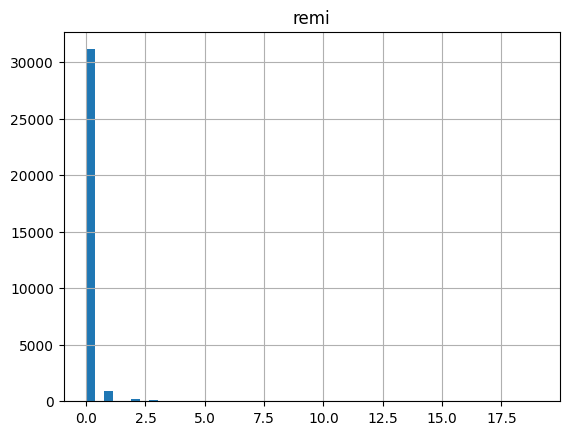

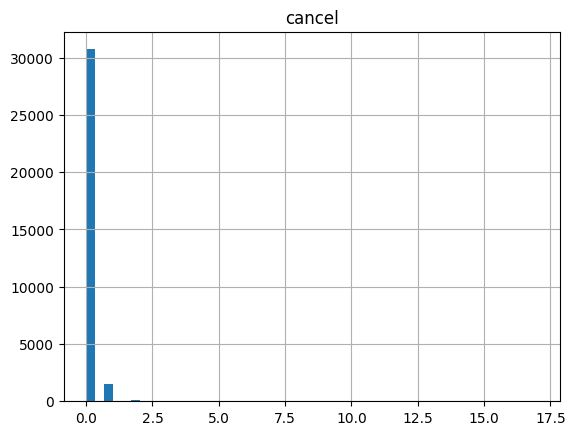

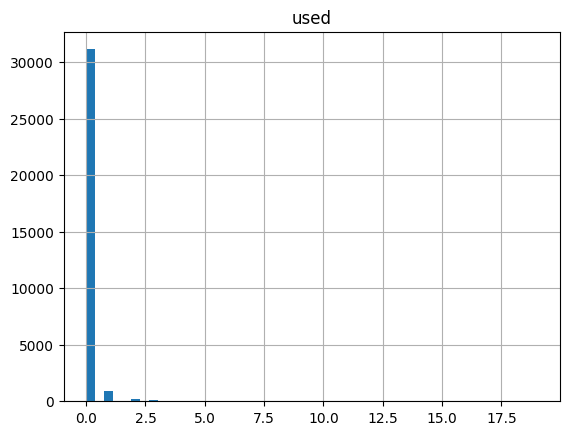

In [87]:
plot_cols = [c for c in ["numberitems", "weight", "remi", "cancel", "used"] if c in train.columns]

for c in plot_cols:
    plt.figure()
    train[c].hist(bins=50)
    plt.title(c)
    plt.show()


## 1.8 Categorical checks

We inspect low-cardinality categorical variables to confirm coding and spot rare categories.


In [88]:
cat_candidates = ["salutation", "title", "newsletter", "model", "paymenttype", "deliverytype", "voucher", "gift", "entry", "points", "shippingcosts", "domain", "case"]
for c in [x for x in cat_candidates if x in train.columns]:
    print("\n", c)
    print(train[c].value_counts(dropna=False).head(20))



 salutation
salutation
0    17840
1    11614
2     2974
Name: count, dtype: int64

 title
title
0    32202
1      226
Name: count, dtype: int64

 newsletter
newsletter
0    26932
1     5496
Name: count, dtype: int64

 model
model
1    18808
3     7358
2     6262
Name: count, dtype: int64

 paymenttype
paymenttype
0    15063
1     6549
2     6537
3     4279
Name: count, dtype: int64

 deliverytype
deliverytype
0    25879
1     6549
Name: count, dtype: int64

 voucher
voucher
0    27174
1     5254
Name: count, dtype: int64

 gift
gift
0    32280
1      148
Name: count, dtype: int64

 entry
entry
0    18982
1    13446
Name: count, dtype: int64

 points
points
0    32428
Name: count, dtype: int64

 shippingcosts
shippingcosts
0    27544
1     4884
Name: count, dtype: int64

 domain
domain
12    7734
9     6953
4     6627
8     3694
11    1422
5     1311
2     1196
0     1173
1     1139
6      548
3      381
10     137
7      113
Name: count, dtype: int64

 case
case
4    8648
3    7125
1 

## 1.10 EDA conclusions

The dataset is moderately imbalanced (≈18.7% positive class), contains strong sparsity in some variables, and shows heavy skew and outliers in count-based features.


## 2. Visual exploratory analysis

We visualize selected raw variables to motivate later preprocessing and feature engineering choices.



### 2.1 Target distribution

We confirm class imbalance to justify revenue-based optimization rather than accuracy.


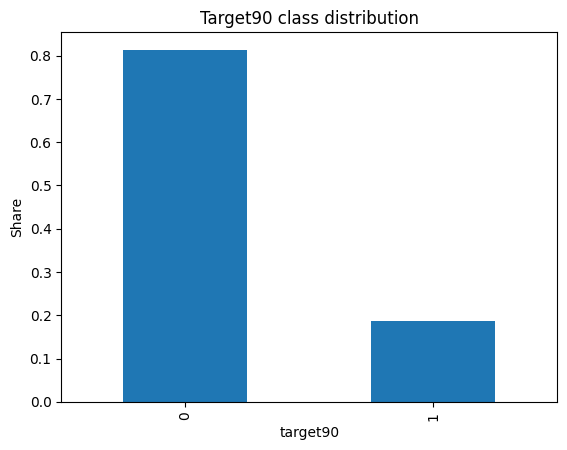

In [89]:
train["target90"].value_counts(normalize=True).plot(
    kind="bar",
    title="Target90 class distribution"
)
plt.ylabel("Share")
plt.show()


### 2.2 Account tenure and reorder behavior

Customer tenure is expected to proxy loyalty and experience.

<Figure size 640x480 with 0 Axes>

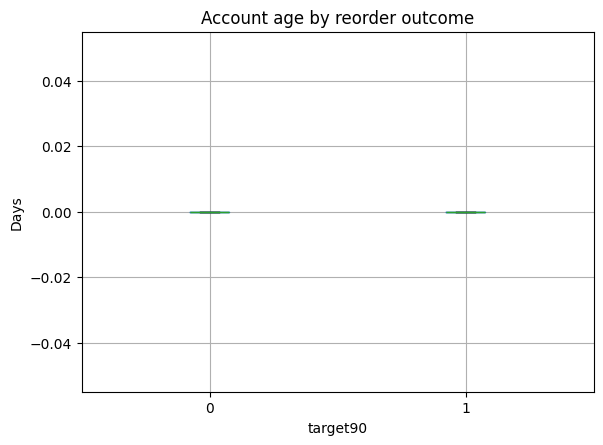

In [90]:
account_age_raw = (
    pd.to_datetime(train["date"], errors="coerce")
    - pd.to_datetime(train["datecreated"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "account_age_days": account_age_raw,
    "target90": train["target90"]
}).boxplot(
    column="account_age_days",
    by="target90",
    showfliers=False
)
plt.title("Account age by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.3 Order size and shipment weight

These variables are highly skewed and may influence reorder probability.


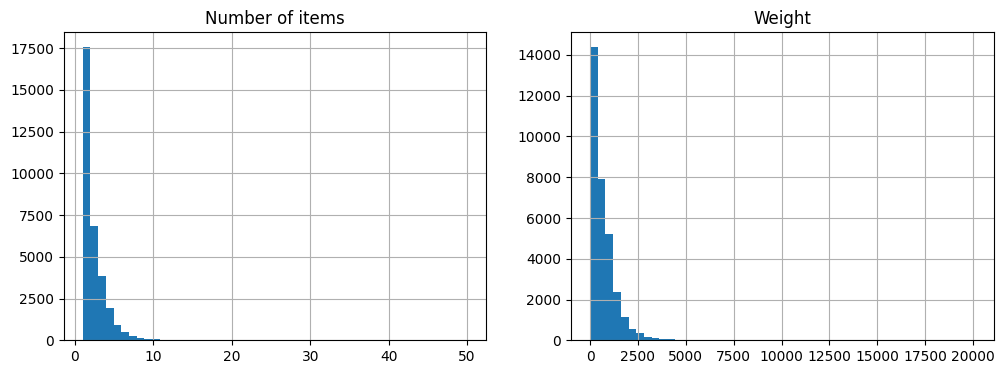

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train["numberitems"].hist(bins=50, ax=axes[0])
axes[0].set_title("Number of items")

train["weight"].hist(bins=50, ax=axes[1])
axes[1].set_title("Weight")

plt.show()


### 2.4 Product-category purchase patterns

Most category counts are sparse with long tails.



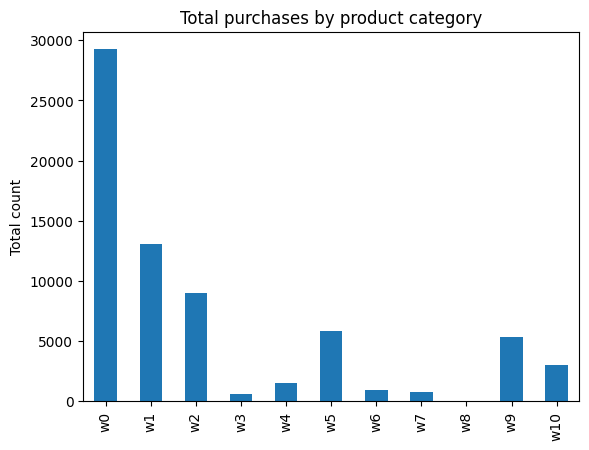

In [92]:
w_cols = [f"w{i}" for i in range(11)]

train[w_cols].sum().plot(
    kind="bar",
    title="Total purchases by product category"
)
plt.ylabel("Total count")
plt.show()



### 2.5 Promised delivery timing

Delivery expectations may influence customer satisfaction and repeat purchases.


<Figure size 640x480 with 0 Axes>

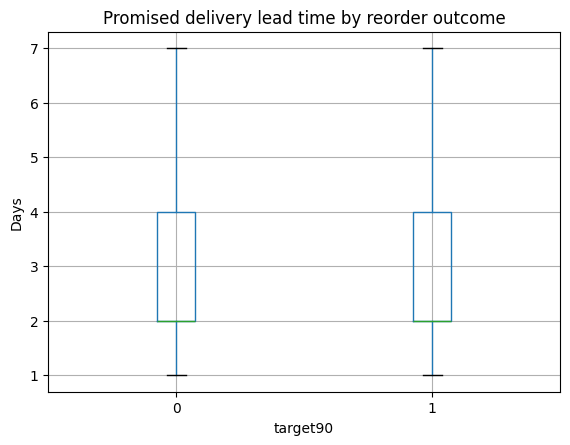

In [93]:
promised_lead_time_raw = (
    pd.to_datetime(train["deliverydatepromised"], errors="coerce")
    - pd.to_datetime(train["date"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "promised_lead_time": promised_lead_time_raw,
    "target90": train["target90"]
}).boxplot(
    column="promised_lead_time",
    by="target90",
    showfliers=False
)
plt.title("Promised delivery lead time by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.6 Incentives and service indicators

We inspect whether basic service and incentive variables differ by reorder behavior.


In [94]:
cat_vars = [
    "salutation", "title", "domain", "newsletter", "model",
    "paymenttype", "deliverytype", "voucher", "gift",
    "entry", "shippingcosts", "case"
]

for c in cat_vars:
    print(c, train[c].nunique())


salutation 3
title 2
domain 13
newsletter 2
model 3
paymenttype 4
deliverytype 2
voucher 2
gift 2
entry 2
shippingcosts 2
case 5


## 3. Data transformations and feature engineering

We construct a leakage-safe baseline feature set and clearly separate optional transformations for later robustness checks.


### 3.1 Feature removal (baseline)

We remove identifiers, constant variables, and features with extreme missingness or leakage risk.


In [95]:
# Copy to avoid modifying raw inspection data
data_fe = train.copy()

# Drop identifier
data_fe.drop(columns=["customernumber"], inplace=True)

# Drop constant feature
data_fe.drop(columns=["points"], inplace=True)

# Drop unusable postcode
data_fe.drop(columns=["delivpostcode"], inplace=True)




### 3.2 Advertising exposure indicator

We retain only the presence of advertising information, not the raw code.


In [96]:
data_fe["has_ad_code"] = data_fe["advertisingdatacode"].notna().astype(int)
data_fe.drop(columns=["advertisingdatacode"], inplace=True)


We believe missingness here can be informative. Raw advertising codes are high-cardnality and sparse

### 3.3 Date parsing

We convert date columns to datetime to enable duration and calendar features.


In [97]:
date_cols = ["date", "datecreated", "deliverydatepromised","deliverydatereal" ]

for c in date_cols:
    data_fe[c] = pd.to_datetime(data_fe[c], errors="coerce")


### 3.4 Time-based features

We extract interpretable duration and calendar features known at order time.


In [98]:
# Customer tenure
data_fe["account_age_days"] = (data_fe["date"] - data_fe["datecreated"]).dt.days

# Order timing
data_fe["order_weekday"] = data_fe["date"].dt.weekday
data_fe["order_month"] = data_fe["date"].dt.month

# Promised delivery timing
data_fe["promised_delivery_weekday"] = data_fe["deliverydatepromised"].dt.weekday
data_fe["promised_delivery_month"] = data_fe["deliverydatepromised"].dt.month

# Promised lead time
data_fe["delivery_difference"] = (
    data_fe["deliverydatereal"] - data_fe["deliverydatepromised"]
).dt.days


### 3.5 Drop raw date variables

After feature extraction, raw datetime columns are no longer needed.


In [99]:
data_fe.drop(columns=["date", "datecreated", "deliverydatepromised","deliverydatereal"], inplace=True)


### 3.6 Product-category aggregation

We summarize sparse product-category counts into a single diversity measure.


In [100]:
w_cols = [f"w{i}" for i in range(11)]
data_fe["product_diversity"] = (data_fe[w_cols] > 0).sum(axis=1)


this reduces dimensionality and preserves signal on breath of engagement

In [101]:
data_fe.isna().sum().sort_values(ascending=False)

delivery_difference          5478
promised_delivery_month         9
promised_delivery_weekday       9
salutation                      0
w9                              0
w3                              0
w4                              0
w5                              0
w6                              0
w7                              0
w8                              0
target90                        0
w10                             0
title                           0
has_ad_code                     0
account_age_days                0
order_weekday                   0
order_month                     0
w2                              0
w1                              0
w0                              0
used                            0
domain                          0
newsletter                      0
model                           0
paymenttype                     0
deliverytype                    0
invoicepostcode                 0
voucher                         0
case          

## 3.7 Outsert the missings 

In [102]:
delay_median = data_fe["delivery_difference"].median()
data_fe["delivery_difference"].fillna(delay_median, inplace=True)

/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_73281/1733387124.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_fe["delivery_difference"].fillna(delay_median, inplace=True)


In [103]:
# we just need the mode for the other variables because the 9 observations are purely negligable
for col in ["promised_delivery_month",
            "promised_delivery_weekday"]:
    data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)

/var/folders/gw/jst10qpx499c9tkkw977rqj00000gn/T/ipykernel_73281/1188255644.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)


## 3.8 Check all data types

In [104]:
data_types = pd.DataFrame({
    "column": data_fe.columns,
    "dtype" : data_fe.dtypes.values
})
data_types

,column,dtype
0,salutation,int64
1,title,int64
2,domain,int64
3,newsletter,int64
4,model,int64
5,paymenttype,int64
6,deliverytype,int64
7,invoicepostcode,int64
8,voucher,int64
9,case,int64


## 3. Data transformations and feature engineering (implemented)

This section documents the feature engineering steps applied to the raw training data prior to building the preprocessing pipeline.

### 3.1 Column removals (data cleaning)
- **Dropped `customernumber`**: identifier only; not meaningful as a predictive feature.
- **Dropped `points`**: constant (zero variance), therefore no predictive value.
- **Dropped `delivpostcode`**: ~95% missingness; too sparse to be informative without heavy imputation.

### 3.2 Advertising information (missingness signal)
- **Created `has_ad_code` = 1 if `advertisingdatacode` is present else 0**, then dropped `advertisingdatacode`.
  - Rationale: the *presence* of tracking information can carry behavioral/marketing signal, while the raw code is high-cardinality and mostly missing.

### 3.3 Datetime conversion (enables time-based features)
Converted the following columns to datetime using `errors="coerce"`:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: ensures consistent parsing and gracefully handles invalid date entries by converting them to `NaT`.

### 3.4 Time-derived customer and order features
Engineered the following features from `date` and `datecreated`:
- **`account_age_days` = `date` − `datecreated`**  
  - Rationale: proxies tenure/relationship maturity, often correlated with retention.
- **`order_weekday`** (0–6) and **`order_month`** (1–12) from `date`  
  - Rationale: captures seasonality and weekday behavioral patterns.

### 3.5 Delivery timing feature
Engineered:
- **`delivery_difference` = `deliverydatereal` − `deliverydatepromised` (days)**  
  - Rationale: delivery experience may affect customer satisfaction and reorder propensity.

After feature extraction, dropped raw datetime columns:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: avoids redundancy and prevents downstream models from using raw timestamps directly.

### 3.6 Product-category aggregation
Created:
- **`product_diversity` = number of product-category counts `w0..w10` that are > 0**
  - Rationale: compresses sparse category information into an interpretable breadth-of-purchase metric while reducing dimensionality.

### 3.7 Missing value handling (post-engineering)
Observed missingness after engineering:
- `delivery_difference`: 5,478 missing (from invalid/missing coerced datetimes)
- `promised_delivery_month`: 9 missing
- `promised_delivery_weekday`: 9 missing

Imputation applied:
- **`delivery_difference` filled with median**
  - Rationale: median is robust to heavy tails and outliers in delay distributions.
- **`promised_delivery_month` and `promised_delivery_weekday` filled with mode**
  - Rationale: very few missing values; mode maintains the most common calendar pattern without distorting scale.

### 3.8 Resulting feature set (current schema)
After transformations, the dataset contains:
- Original integer-coded categorical features: `salutation`, `title`, `domain`, `newsletter`, `model`, `paymenttype`, `deliverytype`, `invoicepostcode`, `voucher`, `case`, `gift`, `entry`, `shippingcosts`
- Numeric/count features: `numberitems`, `weight`, `remi`, `cancel`, `used`, `w0..w10`
- Engineered features: `has_ad_code`, `account_age_days`, `order_weekday`, `order_month`, `promised_delivery_weekday`, `promised_delivery_month`, `delivery_difference`, `product_diversity`
- Target: `target90`

---

## Reversible design choices (for robustness checks)

The following transformations are plausible but not fully “locked in” and should be evaluated via validation expected revenue:

- **[OPTION] Use of `delivery_difference` (derived from `deliverydatereal`)**
  - Risk: potential leakage if voucher decisions occur before real delivery outcomes are known.
  - Robustness test: compare baseline (drop `deliverydatereal`-derived features) vs. variant (include `delivery_difference`).

- **[OPTION] Representation of product-category variables (`w0..w10`)**
  - Variant A: use only raw `w0..w10`
  - Variant B: use only `product_diversity`
  - Variant C: use both
  - Rationale: different representations trade off dimensionality vs. signal.

- **[OPTION] Treat `invoicepostcode` as categorical vs. numeric**
  - Baseline suggestion: one-hot encode (≈100 categories)
  - Variant: keep numeric for tree models (may impose artificial ordering)

- **[OPTION] Transform heavy-tailed numeric variables**
  - Candidates: `weight`, `numberitems`, potentially `w0..w10`
  - Variant: apply `log1p` for linear models or calibration sensitivity checks.

These options will be tracked explicitly and compared under the business objective (expected revenue), not accuracy.


## Parts I am not pretty sure abozt that maybe have flaws
These should be integers: salutation, title, domain, newsletter, model, paymenttype, deliverytype, voucher, gift, entry, shippingcosts

What I would leave the way it is : case;
option here though could be to one hot encode it 

this hsould be categorical : invoicepostcode (0–99): should be categorical.


Moroever, I would keep w0..w10 and product_diversity




In [105]:
# Importnat those categorical variables that I created and should be preserved
for c in ["promised_delivery_weekday", "promised_delivery_month"]:
    data_fe[c] = data_fe[c].astype(int)

data_fe.drop(columns=["invoicepostcode"], inplace=True)

# 4. Data splitting and one-hot encoding

In [106]:
from sklearn.model_selection import train_test_split

X = data_fe.drop(columns=["target90"])
y = data_fe["target90"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## 4.1 One hot encoding

In [107]:
w_cols = [f"w{i}" for i in range(11)]

cat_cols = [
    "salutation","title","domain","newsletter","model",
    "paymenttype","deliverytype","voucher","gift","entry",
    "shippingcosts"
   
]

num_cols = [
    "case",  # keep ordinal in baseline
    "numberitems","weight","remi","cancel","used",
    "has_ad_code","account_age_days","order_weekday","order_month",
    "promised_delivery_weekday","promised_delivery_month",
    "delivery_difference","product_diversity",
    *w_cols
]


In [108]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Preprocessing sanity checks

We confirm that preprocessing produces consistent feature matrices for train and validation.


In [109]:
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)

X_train_t.shape, X_val_t.shape


((24321, 62), (8107, 62))

In [110]:
# Numeric names are unchanged
num_names = num_cols

# One-hot names for categoricals
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()

feature_names = num_names + cat_names
len(feature_names), X_train_t.shape[1]


(62, 62)